In [1]:
#Import the necessary packages
import numpy as np
import pandas as pd
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications.vgg16 import preprocess_input
import matplotlib.image as mpimg
import math
import matplotlib.pyplot as plt
from imutils import paths
import cv2

In [2]:
config={"BATCH_SIZE":32, "DATASET_LOCATION":'dataset/', "FEATURES_OUTPUT":"features.csv"}

#Listing the paths of all our images
imagePaths=list(paths.list_images(config["DATASET_LOCATION"]))

#Extracting the labels from the images
labels={}
for (i,imagepath) in enumerate(imagePaths):
    labels[i]=imagepath.split('/')[1]

In [3]:
#Load our pre-trained model
model=VGG16(weights="imagenet",include_top=False)

In [4]:
#Load the trained features into a dataframe
data=pd.read_csv(config["FEATURES_OUTPUT"])
cols=list(data.columns)

In [5]:
def extract_features(filename):
    '''
    This function loads the image and returns the features of that image.
    
    Input: Name of the image that is stored in current repository
    Output : A numpy array of shape(1,25088) containing the features of the image.
    
    ''' 
    print('[INFO]Extracting features...')
    #Load the image  while ensuring the image is resized to 224x224 pixels
    image=load_img(filename,target_size=(224,224))
    image=img_to_array(image)
    
    #Preprocess the image 
    image = np.expand_dims(image, axis=0)
    image=preprocess_input(image)
    
    # pass the image through the network and use the output as
    # our actual features, then reshape the features into a flattened volume
    features=model.predict(image)
    features=features.reshape(features.shape[0],7*7*512)
    
    return features

In [6]:
def combine_features(features,data,filename,labels):
    '''
    This function combines the features and labels of our input image 
    with the features and labels of our trained images.
    INPUT:
        features:features of the input image
        data:dataframe consisting of the features of the trained images
        filename:name of the input image
        labels: A dictionary where key is the index and its value is the label names.
        
    OUTPUT:
          The dataframe containing the features and the labels dictionary of 
          trained images and our input image.
    '''
    print('[INFO]Combining features...')
    img_data=pd.DataFrame(data=features,columns=cols)
    data=data.append(img_data,ignore_index=True)
    labels[len(labels)]=filename
    
    return (data,labels)

In [7]:
def get_similar_images(N,data,labels,filename):
    '''
    Returns a list containing the paths of the top N similar images.
    INPUT:
        N: No. of similar images we need to find
        data: dataframe consisting of the features of the  images
        labels: A dictionary where key is the index and its value is the label names.
        filename:name of the input image
    OUTPUT:
        A list containing the paths of the top N similar images.      
    '''
    print('[INFO]Getting the paths of the similar images...')
    #Computing the similarity between the features
    from sklearn.metrics.pairwise import cosine_similarity
    cosine_sim = cosine_similarity(data)
    
    # Get the index of the cosine from the label
    for i,label in labels.items():
        if label==filename:
            index=i
            break
    
    #Get the index of the top N similar images 
    similar_images=np.argsort(cosine_sim[index])[::-1][0:N+1]
    
    #Get the imagepaths of the top N similar images
    image_paths=[]
    for i in similar_images:
        path=config['DATASET_LOCATION']+labels[i]
        image_paths.append(path)
        
    #Remove the input image path
    input_image=config['DATASET_LOCATION']+filename
    image_paths.remove(input_image)
    
    return image_paths
    
    

In [8]:
def show_images(imagepaths,N,filename,labels,data):
    '''
    Display the top N similar images to the input image.
    '''
    print('[INFO]Ready to show images...')
    #Resizing the images
    resized=[]
    for i in imagepaths:
        img=mpimg.imread(i)
        resized.append(cv2.resize(img,(180,180)))
    
    #Displaying the images
    rows=math.ceil(N/3)
    input_img=mpimg.imread(filename)
    input_img_resized=cv2.resize(input_img,(180,180))
    plt.imshow(input_img_resized)
    plt.title("Input Image")
    fig,axes=plt.subplots(rows,3,figsize=(25,25))
    axes=axes.ravel()
    print("Showing TOP {} similar images".format(N))
    for i in range(N):
        axes[i].imshow(resized[i])
        #axes[i].axis('off')
        plt.subplots_adjust(bottom=0.3, top=0.6, hspace=0)
        
    
    # Get the index of the cosine from the label
    for i,label in labels.items():
        if label==filename:
            index=i
            break
            
    #Clear the input image label from our trained labels
    labels.pop(index)
    
    #Clear the record of our input image from the dataframe
    data.drop(index=index,inplace=True)  
    

In [9]:
def similar_image_finder(filename,N,data,labels):
    '''
    Display the top N similar images of the given input.
    '''
    
    #Extracting the features of the given input image
    features=extract_features(filename)
    
    #Merging input's data with trained images
    new_data,new_labels=combine_features(features,data,filename,labels)
    
    #Getting the paths of the similar images
    image_paths=get_similar_images(N,new_data,new_labels,filename)
    
    #Displaying the top N similar images
    show_images(image_paths,N,filename,new_labels,new_data)
    
    #Cleaning records
    data=new_data
    labels=new_labels

[INFO]Extracting features...
[INFO]Combining features...
[INFO]Getting the paths of the similar images...
[INFO]Ready to show images...
Showing TOP 6 similar images


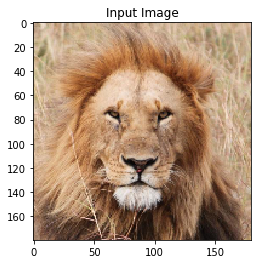

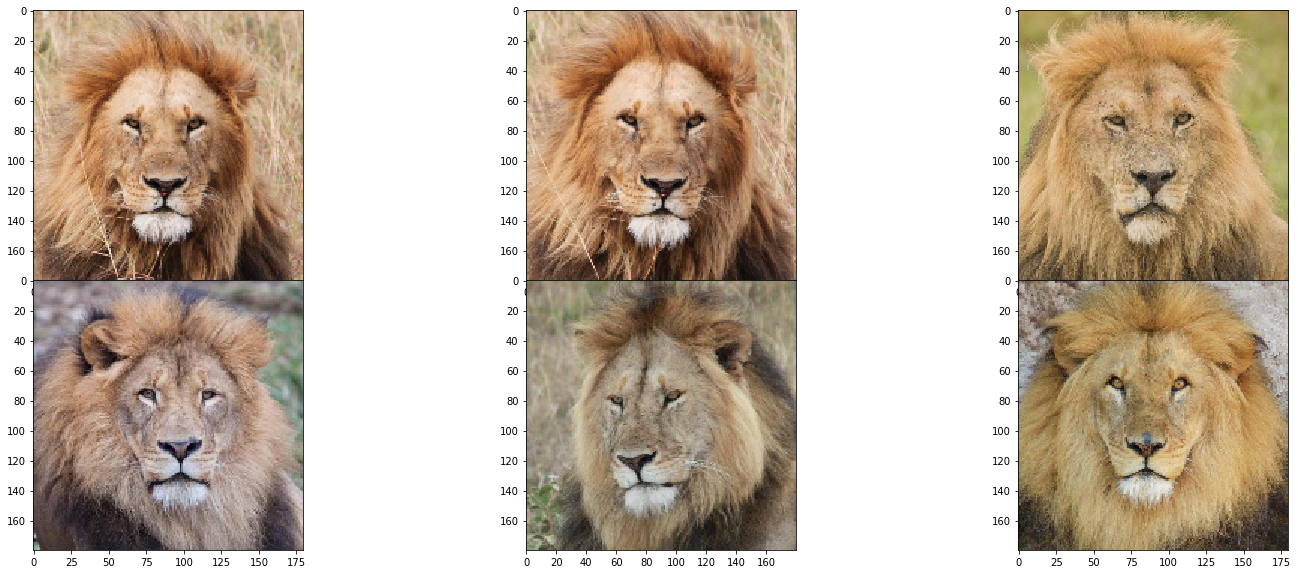

In [10]:
filename="custom3.jpg"
N=6
similar_image_finder(filename,N,data,labels)

[INFO]Extracting features...
[INFO]Combining features...
[INFO]Getting the paths of the similar images...
[INFO]Ready to show images...
Showing TOP 6 similar images


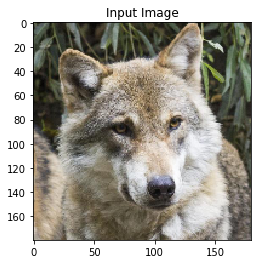

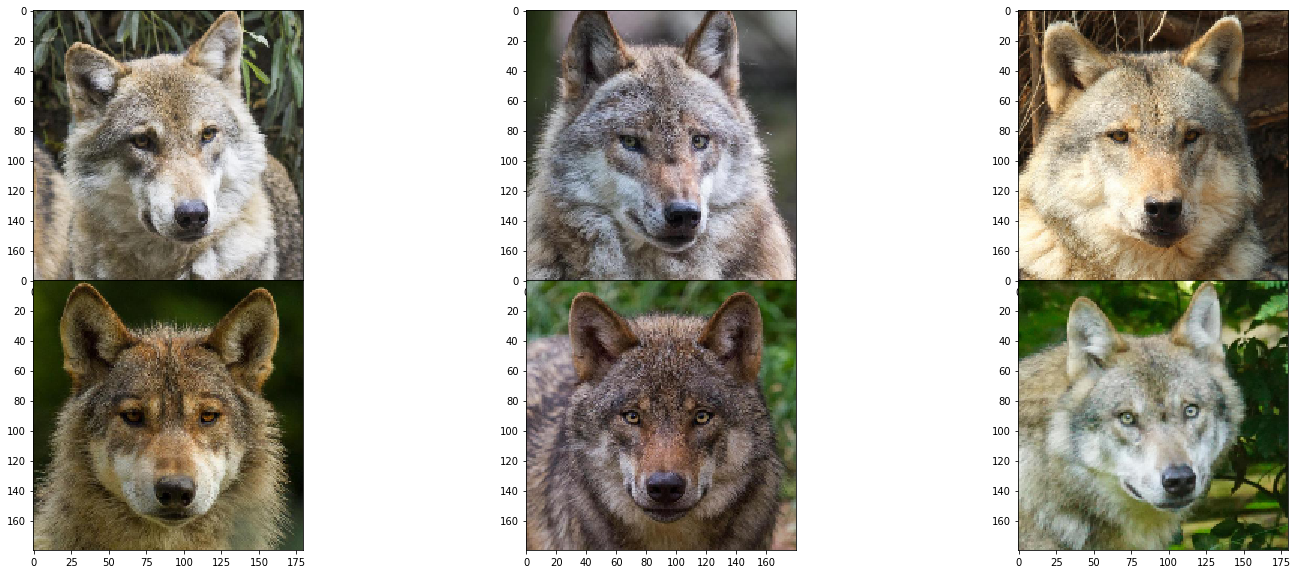

In [11]:
filename="custom2.jpg"
N=6
similar_image_finder(filename,N,data,labels)

[INFO]Extracting features...
[INFO]Combining features...
[INFO]Getting the paths of the similar images...
[INFO]Ready to show images...
Showing TOP 6 similar images


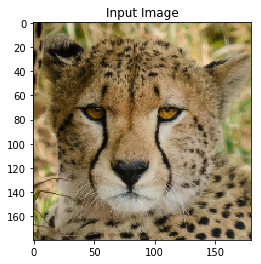

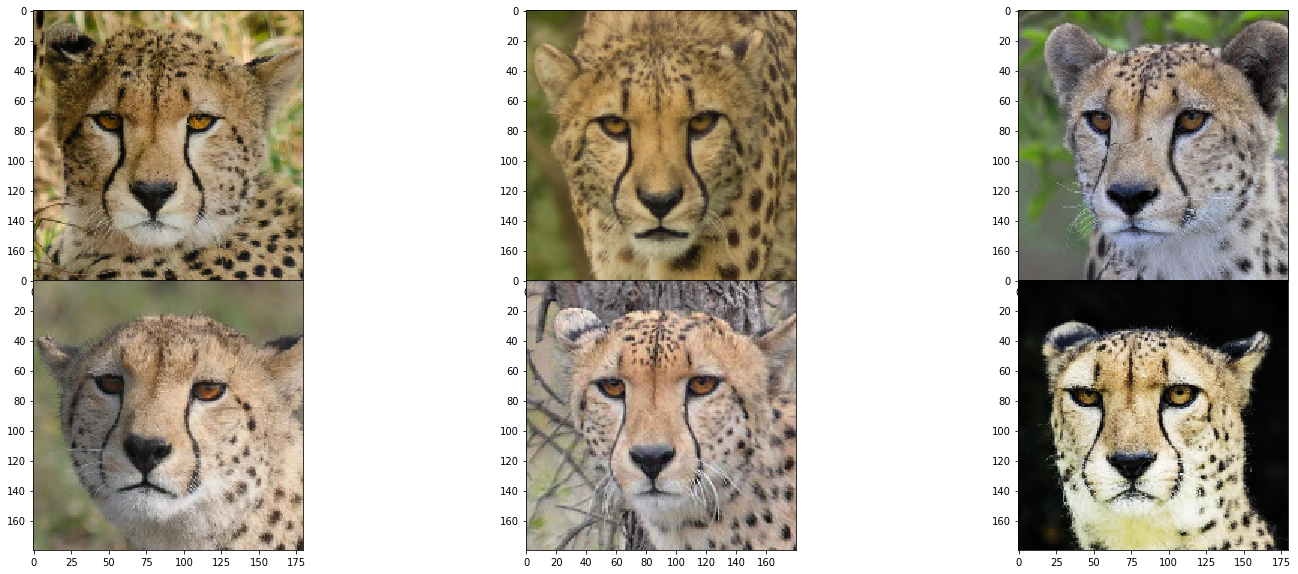

In [12]:
filename="custom.jpg"
N=6
similar_image_finder(filename,N,data,labels)